# Import modules
CDC data set description link [here](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&CycleBeginYear=2015)

In [85]:
import pdb
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
# from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

import nhanes as nhanes

%matplotlib notebook

## Settings

In [2]:
DATA_PATH = 'C:/Users/allen/Documents/Git-Repos/Opportunistic/CDC/NHANES/'
DATASET = 'cancer'

### Note: 
The code below loads each dataset: dataset_features, dataset_targets

Here, all datasets are defined explicitly (see nhanes.py).
*Caution* Very long computation, proceed with care

In [3]:
ds = nhanes.Dataset(DATA_PATH)
ds.load_cancer()
n_fe = ds.features.shape[1]
n_classes = 2

Processing: Dietary\DSQTOT_E.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Processing: Laboratory\BIOPRO_E.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Processing: Laboratory\BIOPRO_G.XPT

Processing: Laboratory\L24PH_C.XPT

Processing: Laboratory\SSMUMP_C.XPT

Processing: Laboratory\UMS_H.XPT

Processing: Questionnaire\ACQ_I.XPT

Processing: Questionnaire\MCQ_H.XPT

Processing: Questionnaire\FSQ_G.XPT

Processing: Questionnaire\WHQ_B.XPT                                                                                

Processing: Questionnaire\DIQ_F.XPT

Processing: Questionnaire\SLQ_H.XPT

Processing: Questionnaire\DBQ_F.XPT                                                                                

Processing: Questionnaire\RHQ.XPT

Processing: Questionnaire\CDQ_C.XPT

Processing: Questionnaire\TBQ_G.XPT

Processing: Questionnaire\ECQ_C.XPT

Processing: Questionnaire\PAQ_H.XPT                                                                                

Processing: Questionnaire\IMQ_D.XPT                                                                                

Processing: Questionnaire\WHQ_H.XPT                                                                                

Processing: Examination\BMX_G.XPT                                                                                

Processing: Examination\AUXTYM.XPT                                                                                

Processing: Laboratory\L13_C.XPT

Processing: Questionnaire\RXQ_RX_C.XPT

Processing: Questionnaire\ACQ_H.XPT

Processing: Questionnaire\CDQ_H.XPT

Processing: Questionnaire\WHQ_H.XPT

Extract the features and targets.

In [4]:
features = ds.features.values
targets = ds.targets.values

indx = np.argwhere(targets != 3)
dataset_features = features[indx.flatten()]
dataset_targets = targets[indx.flatten()]

dataset_features = pd.DataFrame(dataset_features, columns=ds.features.columns)
dataset_targets = pd.DataFrame(dataset_targets, columns=ds.targets.columns, dtype='float64')
print(dataset_targets.shape)
# Pre-fix
# dataset_features = ds.features
# dataset_targets = ds.targets

(98908, 1)


## Preprocessing of Data

### Calculate feature importance

In [5]:
dataset_features_sel = dataset_features.copy()
importances = []
num_trees = 2

for i in range(num_trees):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(dataset_features_sel.values, dataset_targets.values.ravel())
    importances.append(clf.feature_importances_)
    print('0% [',(i+1)*'.',(num_trees-i-1)*'-','] 100%', end='\r')

print('\nDone')

0% [ ..  ] 100%
Done


#### Drop Threshhold helper function

In [6]:
def drop_threshold(threshold, df_data, df_threshold):
    '''
    Sort a 1xn pandas dataframe df_data, return only 
    up to sum of threshold value indicies in df_threshhold
    '''
    mi = df_threshold # mutual information dataframe
    df = df_data # data containing dataframe
    to_keep = []
    mi = mi.sort_values(by=0, axis=1, ascending=False) #sorts the values descending
    # print(mi)
    var_counter = 0
    for col in mi:
        var_counter += mi[col].iloc[0]
        to_keep.append(col)
        if(var_counter > threshold):
            break
    if(len(to_keep) > 0):
        return pd.DataFrame(df[to_keep].copy(), dtype='float64')
    else:
        raise NotImplementedError


#### Drop low importance features

(98908, 83)


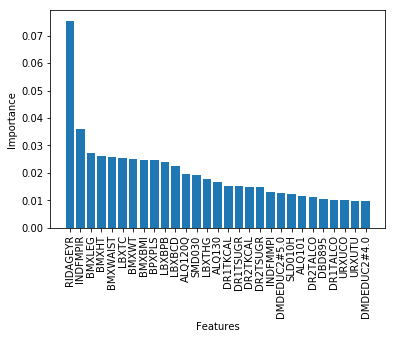

In [7]:
importances_mean = np.array(importances)
importances_mean = np.mean(importances_mean, axis=0)
importances_mean = importances_mean.reshape((1, len(importances_mean)))
importances_mean = pd.DataFrame(importances_mean, columns=ds.features.columns, dtype='float64')
importances_mean = importances_mean.sort_values(by=0, axis=1, ascending=False)

gfs = 29 # number features to show 
df_importances = drop_threshold(0.90, dataset_features_sel, importances_mean)
print(df_importances.shape)

# Visualize Importance:
idx = [i for i in range(len(importances_mean.columns))]
cols = [i for i in importances_mean.columns]
# print(importances_mean.values[0][0:gfs])
plt.bar(idx[0:gfs], importances_mean.values[0][0:gfs])
plt.xticks(idx[0:gfs], importances_mean.columns[0:gfs], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


#### Seperate one-hot encoded, discrete, and continuous features

In [8]:
# onehot encoded
dataset_features_onehot = df_importances.filter(regex=(".*#.*"))
# Continuous 
dataset_features_cont = df_importances.drop(columns=df_importances.filter(regex=(".*#.*")))


print("Original shape: %s" %(df_importances.shape,))
print("Continuous features shape: %s" %(dataset_features_cont.shape,))
print("Categorical features shape: %s "%(dataset_features_onehot.shape,))

Original shape: (98908, 83)
Continuous features shape: (98908, 44)
Categorical features shape: (98908, 39) 


#### Calculate PCA to drop features

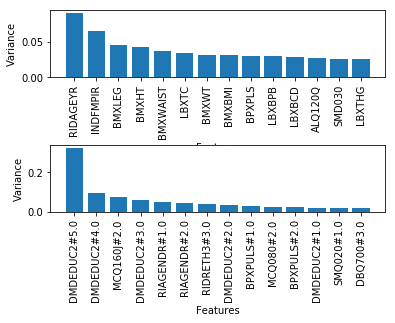

In [9]:
# dfs = [dataset_features_cont.copy(), dataset_features_disc.copy(), dataset_features_onehot.copy()]
dfs_out = [dataset_features_cont.copy(), dataset_features_onehot.copy()]
pca_dfs = []
gfs = 15 # Number of features to graph
gfs -= 1
i = 0
for df in dfs_out:    
#     print(df.shape)
    pca = PCA() # no args, so keep all columns, n_components=2
    pca.fit(df)
    var_ratio = pca.explained_variance_ratio_
    var_ratio = var_ratio.reshape((1, len(var_ratio)))
    pca_dfs.append(pd.DataFrame(data=var_ratio, columns=df.columns))
    # Visualize PCA:
    idx = [i for i in range(len(df.columns))]
    cols = [i for i in df.columns]
    plt.subplot(len(dfs_out),1,i+1)
    plt.subplots_adjust(hspace = 1, top=1, bottom=.3)
    plt.bar(idx[0:gfs], pca.explained_variance_ratio_[0:gfs])
    plt.xticks(idx[0:gfs], df.columns[0:gfs], rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Variance')
    i+=1
plt.show()

# print(pca_dfs.shape)


#### Remove columns that account for too little of the variance

In [10]:
pca_dfs_out = []

for i in range(len(dfs_out)):
    pca_dfs_out.append(drop_threshold(0.7, dfs_out[i] ,pca_dfs[i]))

for df in pca_dfs_out:
    print(df.shape)

df_final = pd.concat(pca_dfs_out, axis=1)
print(df_final.shape)

print('\nFinal list is %s features' %(df_final.shape[1]))
print(df_final.columns)
# for i in df_final.columns:
#     print(i)

(98908, 21)
(98908, 8)
(98908, 29)

Final list is 29 features
Index(['RIDAGEYR', 'INDFMPIR', 'BMXLEG', 'BMXHT', 'BMXWAIST', 'LBXTC', 'BMXWT',
       'BMXBMI', 'BPXPLS', 'LBXBPB', 'LBXBCD', 'ALQ120Q', 'SMD030', 'LBXTHG',
       'ALQ130', 'DR1TKCAL', 'DR1TSUGR', 'DR2TKCAL', 'DR2TSUGR', 'INDFMMPI',
       'SLD010H', 'DMDEDUC2#5.0', 'DMDEDUC2#4.0', 'MCQ160J#2.0',
       'DMDEDUC2#3.0', 'RIAGENDR#1.0', 'RIAGENDR#2.0', 'RIDRETH3#3.0',
       'DMDEDUC2#2.0'],
      dtype='object')


## Train/Test Separation

In [11]:
perm = np.random.permutation(dataset_targets.shape[0])
dataset_targets_vals = np.ravel(dataset_targets.values) # unroll the column to the correct vector shape

dataset_features = df_final.values[perm]
dataset_targets = dataset_targets_vals[perm]

print("dataset_features Shape: %s, dataset_targets Shape: %s" % (dataset_features.shape, dataset_targets.shape))

def get_batch(n_size, phase):
    # select indices
    n_samples = dataset_features.shape[0]
    n_classes = int(dataset_targets.max() + 1)
    if phase == 'test':
        inds_sel = np.arange(0, int(n_samples*0.15), 1)
    elif phase == 'validation':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.15), int(n_samples*0.30), 1)
    elif phase == 'train':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.30), n_samples, 1)
    else:
        raise NotImplementedError
    inds_sel = np.random.permutation(inds_sel)
    batch_inds = []
    for cl in range(n_classes):
        inds_cl = inds_sel[dataset_targets[inds_sel] == cl]
        batch_inds.extend(inds_cl[:n_size//n_classes])
    batch_inds = np.random.permutation(batch_inds)
    
    return dataset_features[batch_inds], dataset_targets[batch_inds]

dataset_features Shape: (98908, 29), dataset_targets Shape: (98908,)


## Validation

In [97]:
validate_svm = True

if validate_svm:
    features_val, targets_val = get_batch(n_size=5000, phase='validation')
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':Cs}
    svc = svm.SVC(gamma="auto")
    clf = GridSearchCV(svc, parameters, cv=5)
    clf.fit(features_val, targets_val)
    print(sorted(clf.cv_results_.keys()))

['mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score', 'param_C', 'param_kernel', 'params', 'rank_test_score', 'split0_test_score', 'split0_train_score', 'split1_test_score', 'split1_train_score', 'split2_test_score', 'split2_train_score', 'split3_test_score', 'split3_train_score', 'split4_test_score', 'split4_train_score', 'std_fit_time', 'std_score_time', 'std_test_score', 'std_train_score']


In [98]:
print(clf.best_params_)

{'C': 0.1, 'kernel': 'linear'}


## Classification

In [100]:
trials = 30
accu_tst_RFC = []
accu_tst_SVC = []
accu_tst_LR = []

for i in range(trials):
    features_trn, targets_trn = get_batch(n_size=5000, phase='train')
    features_tst, targets_tst = get_batch(n_size=1000, phase='test')

    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(features_trn, targets_trn)
    preds_tst = clf.predict(features_tst)
    accu = np.mean(preds_tst==targets_tst)
    # print('accu_tst_RFC', accu)
    accu_tst_RFC.append(accu)

    clf = SVC(kernel='linear', C=0.1)
    clf.fit(features_trn, targets_trn)
    preds_tst = clf.predict(features_tst)
    accu = np.mean(preds_tst==targets_tst)
    # print('accu_tst_SVC', accu)
    accu_tst_SVC.append(accu)

    clf = LogisticRegression(solver='lbfgs', max_iter=200, multi_class='auto')
    clf.fit(features_trn, targets_trn)
    preds_tst = clf.predict(features_tst)
    accu = np.mean(preds_tst==targets_tst)
    # print('accu_tst_LR', accu)
    accu_tst_LR.append(accu)
    print('0% [',(i+1)*'.',(trials-i-1)*'-','] 100%', end='\r')
    
accu_tst_RFC = np.array(accu_tst_RFC)
accu_tst_SVC = np.array(accu_tst_SVC)
accu_tst_LR = np.array(accu_tst_LR)

print("\nDone")

0% [ ..........  ] 100%
Done


In [101]:
print(classification_report(targets_tst, preds_tst))

print('\nAverage accuracies after %s random trials:' %(trials))
print('accu_tst_RFC %.3f, accu_tst_SVC %.3f, accu_tst_LR %.3f'
      % (np.mean(accu_tst_RFC), np.mean(accu_tst_SVC), np.mean(accu_tst_LR)))

print('\nMax accuracies after %s random trials:' %(trials))
print('accu_tst_RFC %.3f, accu_tst_SVC %.3f, accu_tst_LR %.3f'
      % (np.max(accu_tst_RFC), np.max(accu_tst_SVC), np.max(accu_tst_LR)))

              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       500
         1.0       0.80      0.80      0.80       500

   micro avg       0.80      0.80      0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000


Average accuracies after 10 random trials:
accu_tst_RFC 0.831, accu_tst_SVC 0.814, accu_tst_LR 0.801

Max accuracies after 10 random trials:
accu_tst_RFC 0.856, accu_tst_SVC 0.828, accu_tst_LR 0.824


### Hyperparameter Tuning
Define helper functions

In [57]:
def performance(y_true, y_pred, metric="accuracy"):
    """
    Calculates the performance metric based on the agreement between the
    true labels and the predicted labels.

    Parameters
    --------------------
        y_true -- numpy array of shape (n,), known labels
        y_pred -- numpy array of shape (n,), (continuous-valued) predictions
        metric -- string, option used to select the performance measure
                  options: 'accuracy', 'f1-score', 'auroc', 'precision',
                           'sensitivity', 'specificity'

    Returns
    --------------------
        score  -- float, performance score
    """
#     # map continuous-valued predictions to binary labels
    y_label = np.sign(y_pred)
    y_label[y_label == 0] = 1
    y_label[y_label == -1] = 0
#     ones = y_label[y_label == 1]
#     nones = y_label[y_label == -1]
#     print("Values %s" %(np.unique(y_label),))

    # part 2a: compute classifier performance
    if metric == "accuracy":
        return metrics.accuracy_score(y_true, y_label)
    elif metric == "f1_score":
        return metrics.f1_score(y_true, y_label)
    elif metric == "auroc":
        return metrics.roc_auc_score(y_true, y_label)
    elif metric == "precision":
        return metrics.precision_score(y_true, y_label)
    elif metric == "sensitivity":
        c_matrix = metrics.confusion_matrix(y_true, y_label)
        return c_matrix[0, 0] / float(np.sum(c_matrix[0]))
    elif metric == "specificity":
        c_matrix = metrics.confusion_matrix(y_true, y_label)
        return c_matrix[-1, -1] / float(np.sum(c_matrix[-1]))
    else:
        return None

def cv_performance(clf, X, y, kf, metric="accuracy"):
    """
    Splits the data, X and y, into k-folds and runs k-fold cross-validation.
    Trains classifier on k-1 folds and tests on the remaining fold.
    Calculates the k-fold cross-validation performance metric for classifier
    by averaging the performance across folds.

    Parameters
    --------------------
        clf    -- classifier (instance of SVC)
        X      -- numpy array of shape (n,d), feature vectors
                    n = number of examples
                    d = number of features
        y      -- numpy array of shape (n,), binary labels {1,-1}
        kf     -- cross_validation.KFold or cross_validation.StratifiedKFold
        metric -- string, option used to select performance measure

    Returns
    --------------------
        score   -- float, average cross-validation performance across k folds
    """

    skf = kf(n_splits=5)

    p_value = 0
    size = 0
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        dist_pred = clf.decision_function(X_test)
        size += 1
        p_value += performance(y_test, dist_pred, metric=metric)

    p_value /= size
    return p_value

def select_param_linear(X, y, kf, metric="accuracy"):
    """
    Sweeps different settings for the hyperparameter of a linear-kernel SVM,
    calculating the k-fold CV performance for each setting, then selecting the
    hyperparameter that 'maximize' the average k-fold CV performance.

    Parameters
    --------------------
        X      -- numpy array of shape (n,d), feature vectors
                    n = number of examples
                    d = number of features
        y      -- numpy array of shape (n,), binary labels {1,-1}
        kf     -- cross_validation.KFold or cross_validation.StratifiedKFold
        metric -- string, option used to select performance measure

    Returns
    --------------------
        C -- float, optimal parameter value for linear-kernel SVM
    """

    print('Linear SVM Hyperparameter Selection based on ', str(metric), ':')
    C_range = 10.0 ** np.arange(-4, 2)

    # part 2c: select optimal hyperparameter using cross-validation
    perf = None
    c_out = 0
    for c in C_range:
        p = cv_performance(SVC(kernel='linear', C=c),
                           X, y, StratifiedKFold, metric=metric)
        print("c = %s : %s = %s" % (c, metric, p))
        if not perf or p > perf:
            perf = p
            c_out = c

    return c_out


def select_param_rbf(X, y, kf, metric="accuracy"):
    """
    Sweeps different settings for the hyperparameters of an RBF-kernel SVM,
    calculating the k-fold CV performance for each setting, then selecting the
    hyperparameters that 'maximize' the average k-fold CV performance.

    Parameters
    --------------------
        X       -- numpy array of shape (n,d), feature vectors
                     n = number of examples
                     d = number of features
        y       -- numpy array of shape (n,), binary labels {1,-1}
        kf     -- cross_validation.KFold or cross_validation.StratifiedKFold
        metric  -- string, option used to select performance measure

    Returns
    --------------------
        gamma, C -- tuple of floats, optimal parameter values for an RBF-kernel SVM
    """

    print('RBF SVM Hyperparameter Selection based on ', str(metric), ':')

    # part 3b: create grid, then select optimal hyperparameters using cross-validation
    C_range = 10.0 ** np.arange(-4, 2)
    G_range = 10.0 ** np.arange(-5, 1)
    clen = len(C_range)
    glen = len(G_range)

    perf = np.zeros((clen, glen))
    for i in range(clen):
        for j in range(glen):
            perf[i, j] = cv_performance(SVC(kernel='rbf', C=C_range[i], gamma=G_range[j]),
                                        X, y, StratifiedKFold, metric=metric)

    ind = np.unravel_index(np.argmax(perf, axis=None), perf.shape)
    print("score=%s" % perf[ind])
    return G_range[ind[1]], C_range[ind[0]]


def performance_test(clf, X, y, metric="accuracy"):
    """
    Estimates the performance of the classifier using the 95% CI.

    Parameters
    --------------------
        clf          -- classifier (instance of SVC)
                          [already fit to data]
        X            -- numpy array of shape (n,d), feature vectors of test set
                          n = number of examples
                          d = number of features
        y            -- numpy array of shape (n,), binary labels {1,-1} of test set
        metric       -- string, option used to select performance measure

    Returns
    --------------------
        score        -- float, classifier performance
    """
    y_pred = clf.decision_function(X)
    score = performance(y, y_pred, metric=metric)
    return score

Tune hyperparams

In [58]:
X_validate, y_validate = get_batch(n_size=5000, phase='validation')
metric_list = ["accuracy", "f1_score"] # , "auroc", "precision", "sensitivity", "specificity"]
hparams_linear = {}
tune_SVM = False

if tune_SVM:
    for metric in metric_list:
        hparams_linear[metric] = select_param_linear(X_validate, y_validate, StratifiedKFold, metric=metric)

    print(hparams_linear)
# Result: {'accuracy': 0.1, 'f1_score': 0.01}

Linear SVM Hyperparameter Selection based on  accuracy :
c = 0.0001 : accuracy = 0.7931476869670213
c = 0.001 : accuracy = 0.7931476869670213
c = 0.01 : accuracy = 0.8445511030614041
c = 0.1 : accuracy = 0.8464538525394311
c = 1.0 : accuracy = 0.8458199381178779
c = 10.0 : accuracy = 0.8442326365305763
Linear SVM Hyperparameter Selection based on  f1_score :
c = 0.0001 : f1_score = 0.8846427705139941
c = 0.001 : f1_score = 0.8846427705139941
c = 0.01 : f1_score = 0.9048519945298817
c = 0.1 : f1_score = 0.9041790860743149
c = 1.0 : f1_score = 0.9035313839724489
c = 10.0 : f1_score = 0.9024858442708916
{'accuracy': 0.1, 'f1_score': 0.01}


In [60]:
hparams_rbf = {}

if tune_SVM:
    for metric in metric_list:
        hparams_rbf[metric] = select_param_rbf(X_validate, y_validate, StratifiedKFold, metric=metric)

    print(hparams_rbf)
# Result: {'accuracy': (0.01, 1.0), 'f1_score': (0.01, 1.0)}

RBF SVM Hyperparameter Selection based on  accuracy :
score=0.8493094860765226
RBF SVM Hyperparameter Selection based on  f1_score :
score=0.9069710702881568
{'accuracy': (0.01, 1.0), 'f1_score': (0.01, 1.0)}


#### Use tuned SVMs

In [79]:
trials = 10
lin_c = .1
rbf_c = 1
rbf_g = .01
accu_tst_LIN = []
accu_tst_RBF = []

for i in range(trials):
    features_trn, targets_trn = get_batch(n_size=5000, phase='train')
    features_tst, targets_tst = get_batch(n_size=1000, phase='test')


    clf_linear = SVC(kernel='linear', C=lin_c)
    clf_linear.fit(features_trn, targets_trn)
    preds_tst_linear = clf_linear.predict(features_tst)
    accu = np.mean(preds_tst_linear==targets_tst)
    accu_tst_LIN.append(accu)

    clf_rbf = SVC(kernel='rbf', C=rbf_c, gamma='auto') # rbf_g) # auto performs better than rbf_g
    clf_rbf.fit(features_trn, targets_trn)
    preds_tst_rbf = clf_rbf.predict(features_tst)
    accu = np.mean(preds_tst_rbf==targets_tst)
    accu_tst_RBF.append(accu)
    print('0% [',(i+1)*'.',(trials-i-1)*'-','] 100%', end='\r')
    
accu_tst_LIN = np.array(accu_tst_LIN)
accu_tst_RBF = np.array(accu_tst_RBF)


print("\nDone")

0% [ ..........  ] 100%
Done


In [81]:
print('accu_tst_linear = %s, accu_tst_rbf = %s' %(accu_tst_LIN.mean(), accu_tst_RBF.mean()))
# print(accu_tst_LIN)
# print(accu_tst_RBF)
# print(classification_report(targets_tst, preds_tst_linear))
# print(classification_report(targets_tst, preds_tst_rbf))

accu_tst_linear = 0.8152000000000001, accu_tst_rbf = 0.8307


In [82]:
# Adaboost
features_trn, targets_trn = get_batch(n_size=5000, phase='train')
features_tst, targets_tst = get_batch(n_size=1000, phase='test')
clf = AdaBoostClassifier(n_estimators=100, base_estimator=SVC(kernel='rbf', C=rbf_c, gamma='auto', probability=True))
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_ADB', accu)

accu_tst_ADB 0.726


### Accuracies from baseline: 
#### Cancer (ds.load_cancer()):
* accu_tst_RFC 0.758
* accu_tst_SVC 0.759
* accu_tst_LR 0.768

### Calculate mutual information
*Caution* Very long computation, proceed with care
Note: disused because of enmormous memory requirements

In [14]:
# dataset_features_sel_vals = dataset_features_sel.values
# dataset_targets_vals = np.ravel(dataset_targets.values) # unroll the column to the correct vector shape
# # dfs = [dataset_features_cont.copy(), dataset_features_disc.copy(), dataset_features_onehot.copy()]
# # retrieve values from dfs_out for subsequent steps if this comes after PCA
# # dataset_features_cont = dfs_out[0]
# # dataset_features_disc = dfs_out[1]
# # dataset_features_onehot = dfs_out[2]

# print('0% [---] 100%', end='\r')
# mutual_info_cont = mutual_info_regression(dataset_features_cont.values, dataset_targets_vals)
# print('0% [+--] 100%', end='\r')
# # mutual_info_disc = mutual_info_regression(dataset_features_disc.values, dataset_targets_vals)
# # print('0% [++-] 100%', end='\r')
# mutual_info_onehot = mutual_info_classif(dataset_features_onehot.values, dataset_targets_vals)
# print('0% [+++] 100%', end='\r')

### Convert mutual info into dataframes and inspect

In [15]:
# if(mutual_info_cont.shape[0] != 1): # we only need to run this portion of the block once
#     mutual_info_cont = mutual_info_cont.reshape((1, len(mutual_info_cont)))
#     mutual_info_disc = mutual_info_disc.reshape((1, len(mutual_info_disc))) 
#     mutual_info_onehot = mutual_info_onehot.reshape((1, len(mutual_info_onehot))) 


# mutual_info_cont_df = pd.DataFrame(data=mutual_info_cont, columns=dataset_features_cont.columns)
# mutual_info_disc_df = pd.DataFrame(data=mutual_info_disc, columns=dataset_features_disc.columns)
# mutual_info_onehot_df = pd.DataFrame(data=mutual_info_onehot, columns=dataset_features_onehot.columns)

### Dropping features with low mutual information
    __Conditioned on target variable__

In [16]:
# mi_dfs = [mutual_info_cont_df, mutual_info_disc_df, mutual_info_onehot_df]
# dfs = [dataset_features_cont, dataset_features_disc, dataset_features_onehot]
# dfs_out = []

# for i in range(len(dfs)):
#     mi = mi_dfs[i] # mutual information dataframe
#     df = dfs[i] # data containing dataframe
#     to_drop = []
#     mean = 0.25*mi.mean(axis=1)
    
#     # mi = mi.sort_values(by =0, axis=1) #sorts the values ascending
#     # print(mi)
#     for col in mi:
#         if(mi[col].iloc[0] < mean).all():
#             to_drop.append(col)
#     if(len(to_drop) > 0):
#         dfs_out.append(pd.DataFrame(df.drop(columns=to_drop)))
    
# dfs_out = pd.concat(dfs_out, axis=1)
# # Retained columns
# print(dfs_out.columns)
# # output shape
# print(dfs_out.shape)